In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

In [11]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('colorblind')

In [12]:
from imp import reload

In [13]:
def append_path(module_path):
    if module_path not in sys.path:
        sys.path.append(module_path)

append_path(os.path.abspath('..'))

from preprocess import annotated_documents, arg_docs2conll

In [14]:
import read_annotations
import show_metrics
reload(read_annotations);
reload(annotated_documents);
reload(arg_docs2conll);

## Read annotations

In [15]:
ANNOTATIONS_DIR = os.path.join(os.path.expanduser('~'), 'am/data/echr/annotation/')
ANNOTATORS = {
    'C': {'dirname': 'C'}, 'L': {'dirname': 'L'}, 'M': {'dirname': 'M'}, 'S': {'dirname': 'S'}
}

In [16]:
document_pairs, _ = read_annotations.get_annotated_documents(ANNOTATIONS_DIR, ANNOTATORS)
document_pairs

[(Case: ALKASI v. TURKEY - Ann: S, Case: ALKASI v. TURKEY - Ann: M),
 (Case: ALKASI v. TURKEY - Ann: S, Case: ALKASI v. TURKEY - Ann: C),
 (Case: ALKASI v. TURKEY - Ann: S, Case: ALKASI v. TURKEY - Ann: L),
 (Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: C),
 (Case: ALKASI v. TURKEY - Ann: M, Case: ALKASI v. TURKEY - Ann: L),
 (Case: ALKASI v. TURKEY - Ann: C, Case: ALKASI v. TURKEY - Ann: L),
 (Case: PERUS v. SLOVENIA - Ann: S, Case: PERUS v. SLOVENIA - Ann: L),
 (Case: TALMANE v. LATVIA - Ann: M, Case: TALMANE v. LATVIA - Ann: C)]

## Pairing annotations

### Aligning components
We consider two components aligned if they share 80% of the tokens

In [17]:
TOLERANCE = 0.6

In [18]:
def are_aligned(interval1, interval2, plot=False):
    if interval1[0] < interval2[0]:
        start1, end1 = interval1
        start2, end2 = interval2
    elif interval1[0] > interval2[0]:
        start1, end1 = interval2
        start2, end2 = interval1
    else:  # They are equal, we need the interval 1 to be the shorter
        start1, end1 = interval1 if interval1[1] < interval2[1] else interval2
        start2, end2 = interval1 if interval1[1] >= interval2[1] else interval2
    overlap = end1 - start2
    if plot:
        plt.figure(figsize=(6, 2))
        sns.pointplot((interval1[0], interval2[0],interval1[1],interval2[1]),
                      (1,1,1,1), hue=['doc1', 'doc2', 'doc1', 'doc2'])
        plt.show()
    if overlap > (end1 - start1)*TOLERANCE and overlap > (end2 - start2)*0.7:
        return True
    return False

def get_aligned_components(doc1, doc2):
    """Returns a list with components that are aligned between documents"""
    component_starts2 = sorted(doc2.annotated_components.keys())
    component_starts1 = sorted(doc1.annotated_components.keys())
    aligned_components = {}
    # Go through the components of doc1 in ordered fashion.
    while len(component_starts1) is not 0 and len(component_starts2) is not 0:
        start1 = component_starts1[0]
        end1 = doc1.annotated_components[start1]
        start2 = component_starts2[0]
        end2 = doc2.annotated_components[start2]
        # Check if the first components in the stacks are aligned.
        if are_aligned((start1, end1), (start2, end2)):
            aligned_components[start1] = start2
            component_starts2.pop(0)
            component_starts1.pop(0)
        elif start1 >= start2:  # component2 can't be aligned
            component_starts2.pop(0)
        elif start1 <= start2:  # component2 can still be aligned, but not component1
            component_starts1.pop(0)
    return aligned_components

Proportion of aligned components

In [19]:
for doc1, doc2 in document_pairs:
    aligned_components = get_aligned_components(doc1, doc2)
    print('[{0}] {1:.2f} - [{2}] {3:.2f}'.format(
        doc1.identifier.replace('Case: ', ''),
        len(aligned_components)/float(len(doc1.annotated_components)),
        doc2.identifier.replace('Case: ', ''),
        len(aligned_components)/float(len(doc2.annotated_components))))

[ALKASI v. TURKEY - Ann: S] 0.74 - [ALKASI v. TURKEY - Ann: M] 0.78
[ALKASI v. TURKEY - Ann: S] 0.66 - [ALKASI v. TURKEY - Ann: C] 0.75
[ALKASI v. TURKEY - Ann: S] 0.72 - [ALKASI v. TURKEY - Ann: L] 0.74
[ALKASI v. TURKEY - Ann: M] 0.85 - [ALKASI v. TURKEY - Ann: C] 0.92
[ALKASI v. TURKEY - Ann: M] 0.89 - [ALKASI v. TURKEY - Ann: L] 0.86
[ALKASI v. TURKEY - Ann: C] 0.86 - [ALKASI v. TURKEY - Ann: L] 0.77
[PERUS v. SLOVENIA - Ann: S] 0.89 - [PERUS v. SLOVENIA - Ann: L] 0.61
[TALMANE v. LATVIA - Ann: M] 0.48 - [TALMANE v. LATVIA - Ann: C] 0.76


### Aligning relations

In [20]:
def align_relations(doc1, doc2):
    aligned_relations = []
    # We iterate over the components
    aligned_components = get_aligned_components(doc1, doc2)
    for arg1_start1, arg1_start2 in aligned_components.items():
        if not (arg1_start1 in doc1.annotated_relations.keys() and
                arg1_start2 in doc2.annotated_relations.keys()):
            continue
        # Check if the relations are equal
        # We iterate over the relations starting from that component.
        for arg2_start1 in doc1.annotated_relations[arg1_start1].keys():
            if arg2_start1 not in aligned_components:
                # The second argument of the relation is not aligned, then
                # the relation is not aligned
                continue
            # The second component is aligned, now we check if the same relation
            # exists on the second document
            arg2_start2 = aligned_components[arg2_start1]
            if arg2_start2 in doc2.annotated_relations[arg1_start2]:
                # The relation is aligned!!
                aligned_relations.append(
                    ((arg1_start1, arg2_start1),(arg1_start2, arg2_start2)))
    return aligned_relations

Proportion of aligned relations

In [21]:
for doc1, doc2 in document_pairs:
    aligned_relations = align_relations(doc1, doc2)
    print('[{0}] {1:.2f} - [{2}] {3:.2f}'.format(
        doc1.identifier.replace('Case: ', ''),
        len(aligned_relations)/float(len(doc1.annotated_relations)),
        doc2.identifier.replace('Case: ', ''),
        len(aligned_relations)/float(len(doc2.annotated_relations))))

[ALKASI v. TURKEY - Ann: S] 0.32 - [ALKASI v. TURKEY - Ann: M] 0.26
[ALKASI v. TURKEY - Ann: S] 0.24 - [ALKASI v. TURKEY - Ann: C] 0.21
[ALKASI v. TURKEY - Ann: S] 0.37 - [ALKASI v. TURKEY - Ann: L] 0.29
[ALKASI v. TURKEY - Ann: M] 0.57 - [ALKASI v. TURKEY - Ann: C] 0.63
[ALKASI v. TURKEY - Ann: M] 0.57 - [ALKASI v. TURKEY - Ann: L] 0.56
[ALKASI v. TURKEY - Ann: C] 0.35 - [ALKASI v. TURKEY - Ann: L] 0.31
[PERUS v. SLOVENIA - Ann: S] 0.39 - [PERUS v. SLOVENIA - Ann: L] 0.21
[TALMANE v. LATVIA - Ann: M] 0.10 - [TALMANE v. LATVIA - Ann: C] 0.17


## Agreement on aligned relations

In [22]:
def aligned_labels(aligned_relations, doc1, doc2):
    labels1 = []
    labels2 = []
    for (arg1_start1, arg2_start1), (arg1_start2, arg2_start2) in aligned_relations:
        labels1.append(doc1.annotated_relations[arg1_start1][arg2_start1])
        labels2.append(doc2.annotated_relations[arg1_start2][arg2_start2])
    return labels1, labels2

Case: ALKASI v. TURKEY - Ann: S Case: ALKASI v. TURKEY - Ann: M
Observed Agreement: 91.67%


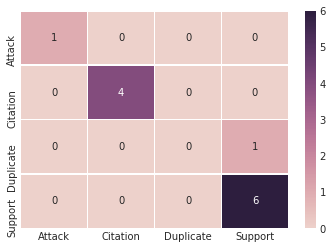

Case: ALKASI v. TURKEY - Ann: S Case: ALKASI v. TURKEY - Ann: C
Observed Agreement: 100.00%


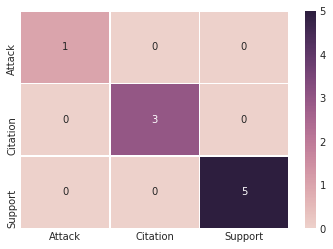

Case: ALKASI v. TURKEY - Ann: S Case: ALKASI v. TURKEY - Ann: L
Observed Agreement: 71.43%


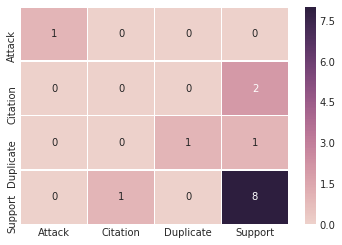

Case: ALKASI v. TURKEY - Ann: M Case: ALKASI v. TURKEY - Ann: C
Observed Agreement: 88.89%


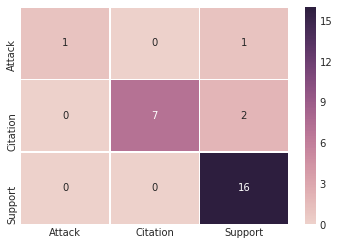

Case: ALKASI v. TURKEY - Ann: M Case: ALKASI v. TURKEY - Ann: L
Observed Agreement: 85.19%


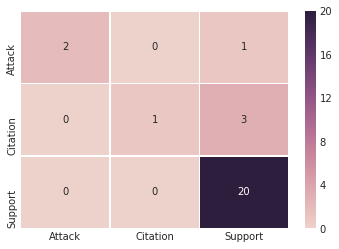

Case: ALKASI v. TURKEY - Ann: C Case: ALKASI v. TURKEY - Ann: L
Observed Agreement: 93.33%


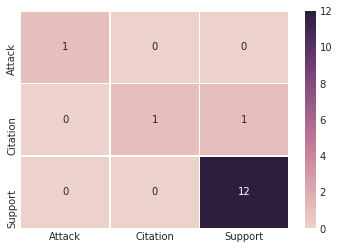

Case: PERUS v. SLOVENIA - Ann: S Case: PERUS v. SLOVENIA - Ann: L
Observed Agreement: 94.74%


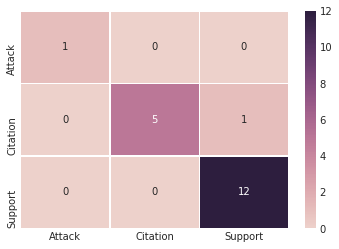

Case: TALMANE v. LATVIA - Ann: M Case: TALMANE v. LATVIA - Ann: C
Observed Agreement: 100.00%


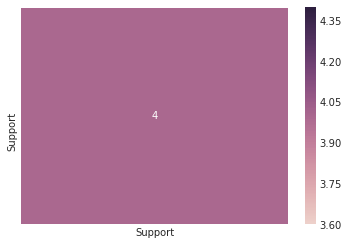

In [23]:
for doc1, doc2 in document_pairs:
    aligned_relations = align_relations(doc1, doc2)
    labels1, labels2 = aligned_labels(aligned_relations, doc1, doc2)
    print(doc1, doc2)
    show_metrics.show_confusion_matrix(labels1, labels2)